In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Temporary Input

In [ ]:
enc_input = torch.tensor([[3091, 3604, 206 , 777, 0]], dtype=torch.long).to(device)
dec_input = torch.tensor([[1, 8282, 1577, 4885, 3, 0, 0]], dtype=torch.long).to(device)
print(enc_input.shape)
print(dec_input.shape)

torch.Size([1, 5])
torch.Size([1, 7])


In [ ]:
d_model = 512   # Embedding vector의 차원
vocab_size = 10000

word_embed_layer = nn.Embedding(vocab_size, d_model, padding_idx=0).to(device)
word_embedding = word_embed_layer(enc_input)
print(word_embedding.size())

torch.Size([1, 5, 512])


## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, len_seq, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(len_seq, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [ ]:
import numpy as np

# Positional encoding을 가져오는 함수
def make_pos_encoding(len_seq, d_model):
    # 결과를 담을 행렬 생성
    result_mat = np.zeros((len_seq, d_model))

    # pos와 나눌 분모 값 계산
    angle_div = [np.power(10000, ((2 * i) / d_model)) for i in range(d_model // 2)]

    # pos를 iterate하며 sine, cosine 값 계산
    for pos in range(len_seq):
        pe_sin = [np.sin(pos / div) for div in angle_div]
        pe_cos = [np.cos(pos / div) for div in angle_div]

        # 결과 행렬에 저장
        result_mat[pos, 0::2] = pe_sin # 0, 2, 4, ... (짝수)
        result_mat[pos, 1::2] = pe_cos # 1, 3, 5, ... (홀수)
    
    return result_mat

(64, 512)


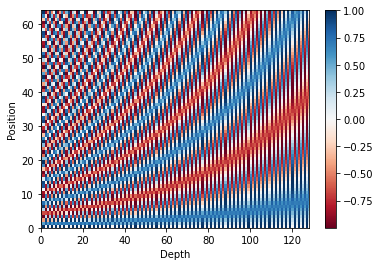

In [ ]:
import matplotlib.pyplot as plt

# 여기서 예시로 간단히 사용한 8개의 단어로 이루어지고, 각 단어는 512 차원의 임베딩벡터로 이루어질 경우
pos_encoding = make_pos_encoding(len_seq=64, d_model=512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding, cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

pos_encoding = torch.FloatTensor(pos_encoding).to(device)

In [ ]:
# 앞서 구한 positional encoding으로 embedidng layer를 초기화하고 freeze
pos_embed_layer = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

# pos_embed_layer에서 값을 꺼내오기 위한 position sequence 생성
positions = torch.arange(word_embedding.size(1)).expand(word_embedding.size(0), word_embedding.size(1)).to(device)

print(positions)

# input embedding과 더해줄 positional embedding 생성
pos_embedding = pos_embed_layer(positions)
print(pos_embedding.size())

tensor([[0, 1, 2, 3, 4]], device='cuda:0')
torch.Size([1, 5, 512])


In [ ]:
# 단어 임베딩과 위치 임베딩을 합한 임베딩
enc_embedding = word_embedding + pos_embedding
print(enc_embedding.shape)

torch.Size([1, 5, 512])


## Mask

In [ ]:
def make_src_mask(src, pad_idx=0, device='cpu'):
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2).to(device)
    src_mask.logical_not_() # 0이 되어야 할 위치에 True가 오도록 True <-> False 반전
    # (batch_size, 1, 1, src_len)
    return src_mask


src_mask = make_src_mask(src=enc_input, pad_idx=0, device=device)
print(src_mask.size())
print(src_mask)

torch.Size([1, 1, 1, 5])
tensor([[[[False, False, False, False,  True]]]], device='cuda:0')


In [ ]:
# target 문장에서 다음 단어에 대해 0으로된 마스크 생성(다음 단어를 모르게하여 cheating 방지)
# target 문장에도 <pad> 토큰이 있을 수 있으므로, 같이 고려함
def make_trg_mask(trg, pad_idx=0, device='cpu'):
    # trg shape: (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    trg_pad_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(2)

    seq_len = trg.size(1)
    trg_sub_mask = torch.tril(torch.ones((seq_len, seq_len)).to(device)).bool()
    
    trg_mask = trg_pad_mask & trg_sub_mask
    trg_mask.logical_not_() # 0이 되어야 할 위치에 True가 오도록 True <-> False 반전
    return trg_mask


trg_mask = make_trg_mask(trg=dec_input, pad_idx=0, device=device)
print(trg_mask.size())
print(trg_mask)

torch.Size([1, 1, 7, 7])
tensor([[[[False,  True,  True,  True,  True,  True,  True],
          [False, False,  True,  True,  True,  True,  True],
          [False, False, False,  True,  True,  True,  True],
          [False, False, False, False,  True,  True,  True],
          [False, False, False, False, False,  True,  True],
          [False, False, False, False, False,  True,  True],
          [False, False, False, False, False,  True,  True]]]],
       device='cuda:0')


## Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head, device):
        super().__init__()

        self.n_head = n_head                # attention head 갯수
        self.d_head = d_model // n_head     # 각 head당 차원

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)
        self.linear = nn.Linear(d_model, d_model)
        # 계산량을 줄이기 위해 미리 나눌 값을 계산해 둔다.
        self.scale = 1 / torch.sqrt(torch.FloatTensor([self.d_head])).to(device)

    def forward(self, Q, K, V, mask):
        Q = self.W_Q(Q)
        K = self.W_K(K)
        V = self.W_V(V)

        # Q, K, V를 각 attention head로 분리
        Q = Q.view(Q.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)

        # attention을 구한 다음 스케일링과 패딩마스크로 처리한다.
        Z = (torch.matmul(Q, K.permute(0, 1, 3, 2)) * self.scale).masked_fill_(mask, -1e10)
        Z = torch.matmul(self.softmax(Z), V)

        # n_head랑 len_seq차원 위치 변경 + head 나눠져있던것 합치기
        Z = Z.permute(0, 2, 1, 3).contiguous()
        Z = Z.view(Z.size(0), -1, self.d_head * self.n_head)
        
        # 마지막 linear layer 적용
        out = self.linear(Z)
        return out

In [ ]:
# 앞에서 계산한 최종 임베딩이 입력이라고 가정
X = enc_embedding
print(X.size())

att = MultiHeadAttention(d_model=512, n_head=8, device=device).to(device)
out = att(X, X, X, src_mask)
print(out.size())

torch.Size([1, 5, 512])
torch.Size([1, 5, 512])


## Positionwise Feedforward

In [ ]:
class PoswiseFeedForward(nn.Module):
    def __init__(self, d_model, drop_ratio):
        super().__init__()

        self.hidden_layer = nn.Linear(d_model, d_model*4)
        self.output_layer = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, input):
        X = self.hidden_layer(input)
        X = self.dropout(torch.relu(X))
        X = self.output_layer(X)
        return X

In [ ]:
pff = PoswiseFeedForward(d_model=512, drop_ratio=0.1).to(device)
out = pff(out)
print(out.size())

torch.Size([1, 5, 512])


## Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, drop_ratio, device):
        super().__init__()
        
        self.attention = MultiHeadAttention(d_model, n_head, device)
        self.norm1 = nn.LayerNorm(d_model)
        self.pff = PoswiseFeedForward(d_model, drop_ratio)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_ratio)
    
    def forward(self, enc_input, mask):
        # sublayer1 - multi head attention
        att_out = self.attention(enc_input, enc_input, enc_input, mask)
        X = self.norm1(self.dropout(att_out) + enc_input)

        # sublayer2 = poswise feed forward
        pff_out = self.pff(X)
        out = self.norm2(self.dropout(pff_out) + X)
        return out

In [ ]:
X = enc_embedding
print(X.size())

encorder_layer = EncoderLayer(d_model=512, n_head=8, drop_ratio=0.1, device=device).to(device)
out = encorder_layer(X, src_mask)
print(out.size())

torch.Size([1, 5, 512])
torch.Size([1, 5, 512])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_head, n_layer, drop_ratio, max_len_seq, device):
        super().__init__()

        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)

        self.word_embed_layer = nn.Embedding(input_dim, d_model, padding_idx=0)
        pos_encoding = torch.FloatTensor(make_pos_encoding(max_len_seq, d_model))
        self.pos_embed_layer = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, n_head, drop_ratio, device) for _ in range(n_layer)])
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, enc_input, src_mask):
        word_embedding = self.word_embed_layer(enc_input) * self.scale

        positions = torch.arange(enc_input.size(1)).expand(enc_input.size(0), enc_input.size(1)).to(self.device)
        pos_embedding = self.pos_embed_layer(positions)
        
        X = self.dropout(word_embedding + pos_embedding)

        for layer in self.encoder_layers:
            X = layer(X, src_mask)

        return X

In [ ]:
print(enc_input)
print(enc_input.shape)

encoder = Encoder(input_dim=vocab_size, d_model=512, n_head=8, drop_ratio=0.1,
                  n_layer=6, max_len_seq=100, device=device).to(device)
out = encoder(enc_input, src_mask)
print(out.shape)

tensor([[3091, 3604,  206,  777,    0]], device='cuda:0')
torch.Size([1, 5])
torch.Size([1, 5, 512])


## Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, drop_ratio, device):
        super().__init__()

        self.self_att = MultiHeadAttention(d_model, n_head, device)
        self.norm1 = nn.LayerNorm(d_model)
        
        self.enc_dec_att = MultiHeadAttention(d_model, n_head, device)
        self.norm2 = nn.LayerNorm(d_model)

        self.pff = PoswiseFeedForward(d_model, drop_ratio)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_ratio)
    
    def forward(self, dec_input, enc_output, src_mask, trg_mask):
        self_att_out = self.self_att(dec_input, dec_input, dec_input, trg_mask)
        X = self.norm1(self.dropout(self_att_out) + dec_input)

        enc_dec_att_out = self.enc_dec_att(X, enc_output, enc_output, src_mask)
        X = self.norm2(self.dropout(enc_dec_att_out) + X)

        pff_out = self.pff(X)
        out = self.norm3(self.dropout(pff_out) + X)
        return out

In [ ]:
word_embedding = word_embed_layer(dec_input)
print(word_embedding.size())

positions = torch.arange(word_embedding.size(1)).expand(word_embedding.size(0), word_embedding.size(1)).to(device)
print(positions)

pos_embedding = pos_embed_layer(positions)
print(pos_embedding.size())

dec_embedding = word_embedding + pos_embedding
print(dec_embedding.size())

decorder_layer = DecoderLayer(d_model=512, n_head=8, drop_ratio=0.1, device=device).to(device)
out2 = decorder_layer(dec_embedding, out, src_mask, trg_mask)
print(out2.size())

torch.Size([1, 7, 512])
tensor([[0, 1, 2, 3, 4, 5, 6]], device='cuda:0')
torch.Size([1, 7, 512])
torch.Size([1, 7, 512])
torch.Size([1, 7, 512])


In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, d_model, n_head, n_layer, drop_ratio, max_len_seq, device):
        super().__init__()

        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)

        self.word_embed_layer = nn.Embedding(input_dim, d_model, padding_idx=0)
        pos_encoding = torch.FloatTensor(make_pos_encoding(max_len_seq, d_model))
        self.dropout = nn.Dropout(drop_ratio)

        self.pos_embed_layer = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, n_head, drop_ratio, device) for _ in range(n_layer)])
        self.fc_out = nn.Linear(d_model, input_dim)

    def forward(self, dec_input, enc_output, src_mask, trg_mask):
        word_embedding = self.word_embed_layer(dec_input) * self.scale

        positions = torch.arange(dec_input.size(1)).expand(dec_input.size(0), dec_input.size(1)).to(self.device)
        pos_embedding = self.pos_embed_layer(positions)

        X = self.dropout(word_embedding + pos_embedding)

        for layer in self.decoder_layers:
            X = layer(X, enc_output, src_mask, trg_mask)

        X = self.fc_out(X)
        return X

In [ ]:
print(dec_input)
print(dec_input.shape)

decoder = Decoder(input_dim=vocab_size, d_model=512, n_head=8, drop_ratio=0.1,
                  n_layer=6, max_len_seq=100, device=device).to(device)
out2 = decoder(dec_input, out, src_mask, trg_mask)
print(out2.shape)

tensor([[   1, 8282, 1577, 4885,    3,    0,    0]], device='cuda:0')
torch.Size([1, 7])
torch.Size([1, 7, 10000])


## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, enc_vocab_size, enc_pad_idx, enc_max_seq,
                 dec_vocab_size,  dec_pad_idx, dec_max_seq, device,
                 *, d_model=512, n_head=8, drop_ratio=0.1, n_layer=6):
        super().__init__()

        self.device = device
        self.enc_pad_idx = enc_pad_idx
        self.dec_pad_idx = dec_pad_idx
        self.encoder = Encoder(enc_vocab_size, d_model, n_head, n_layer, drop_ratio, enc_max_seq, device)
        self.decoder = Decoder(dec_vocab_size, d_model, n_head, n_layer, drop_ratio, dec_max_seq, device)

    def forward(self, X, Y):
        src_mask = make_src_mask(X, pad_idx=self.enc_pad_idx, device=self.device)
        trg_mask = make_trg_mask(Y, pad_idx=self.dec_pad_idx, device=self.device)

        enc_output = self.encoder(X, src_mask)
        dec_output = self.decoder(Y, enc_output, src_mask, trg_mask)
        return dec_output

In [ ]:
model = Transformer(10000, 0, 5, 10000, 0, 6, device).to(device)
output = model(enc_input, dec_input[:,:-1])
output.size()

torch.Size([1, 6, 10000])

## Translate Data

In [ ]:
!pip install konlpy
!pip install sentencepiece

In [ ]:
import pandas as pd

df_origin = pd.read_excel('/content/drive/MyDrive/ko_en_190920.xlsx')
df_origin

,Temp,한국어,영어,영어 검수
0,15005,나는 네가 한국 언어를 배워서 한국어로 대화했으면 좋겠어.,I want you to learn Korean and talk with me in...,I want you to learn Korean so that we can talk...
1,15006,나는 대략 한 시간 정도 이 창고를 돌아 보기를 원합니다.,I want to look around this warehouse for about...,I want to look around this warehouse for about...
2,15007,때를 미는 한국의 목욕법을 체험해보고 싶은데 가능할까요?,"I want to experience Korean skin peeling, but ...",I want to experience a Korean skin peeling bat...
3,15008,우리들 또한 당신들과 함께 한다면 큰 영광일 것입니다.,It will be truly honored for us to work with you.,It will be truly honored for us to work with you.
4,15016,나는 네가 한국의 감탄사를 사용한다는 말에 놀랐다.,I was surprised that you used Korea's exclamat...,I was surprised to hear that you are using Kor...
...,...,...,...,...
9994,2229,아침에 물 흐르는 좋은 소리를 들었습니다.,I heard the water is running in the morning.,I heard the water flows in the morning.
9995,2240,Anne은 여름 휴가를 어떻게 보낼 것인가요?,How will Anne spend the summer vacation?,What is Anne's plan for the summer vacation?
9996,2242,이번 여름 휴가는 일본에 가려고 했어요.,I have planned to go Japan this summer vacation.,I had a plan to go to Japan this summer vacation.
9997,2243,설 연휴 휴무 일정이 어떻게 되나요?,What are the New Year’s holiday schedules?,When is the New Year’s holiday?


In [ ]:
from konlpy.tag import Okt

class OktTokenizer(Okt):
    def __init__(self, sentences):
        super().__init__()
        
        words = set()
        max_len = 0
        for sentence in sentences:
            morphs = self.morphs(sentence)
            max_len = max(len(morphs), max_len)
            words.update(morphs)

        self.max_len = max_len
        self.vocab_size = len(words) + 1
        self.word_to_index = {word:index for index, word in enumerate(words, start=1)}
        self.word_to_index[0] = '<PAD>'
        self.index_to_word = {index:word for word, index in self.word_to_index.items()}
        
    
    def encode(self, sentence):
        morphs = self.morphs(sentence)
        morphs = [self.word_to_index[word] for word in morphs]
        morphs.extend([0] * (self.max_len - len(morphs)))
        return morphs
    
    
    def decode(self, sentence):
        return ' '.join(self.index_to_word[i] if i!=0 else '<PAD>' for i in sentence)

In [ ]:
ko_tokenizer = OktTokenizer(df_origin['한국어'])

In [ ]:
f'토큰화된 단어의 개수 : {ko_tokenizer.vocab_size}'

'토큰화된 단어의 개수 : 12285'

In [ ]:
a = ko_tokenizer.encode('때를 미는 한국의 목욕법을 체험해보고 싶은데 가능할까요?')
print(a)

[6023, 11785, 5157, 4918, 1339, 8044, 12129, 194, 9503, 7613, 10206, 5851, 4094, 6727, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
ko_tokenizer.decode(a)

'때 를 미는 한국 의 목욕 법 을 체험 해보고 싶은데 가능할까 요 ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [ ]:
en_data = df_origin['영어 검수'].map(lambda s: s.lower())

In [ ]:
with open('/content/drive/MyDrive/en_translate.txt','w') as w:
    w.write('\n'.join(en_data))

In [ ]:
words = set()
en_data.map(lambda s: words.update([w for w in s.split()]))
print(words)
len(words)

{'realigns', 'grade', 'customers,', 'compatibility.', 'markers', 'kind.', 'drawn', 'bank', 'certainly.', 'roommate.', 'machine,', 'marinated', 'cuisine', 'different.', 'a-frame', 'ordering', 'unnecessary', 'air?', 'disposable', "ceo's", 'enterprise.', 'food.', 'trip,', 'defense', 'metal', 'blossoms', 'simple.', 'issue', 'biscuits.', 'diamond', 'apron.', 'maritime', 'india.', 'egg.', 'products', 'growing', 'thirty', 'soup#', 'opposite', 'option', 'consumer', 'record?', 'harassment.', 'export', 'coins.', 'routes', 'fair-weather', 'delivery.', 'sydney', 'recycled', 'harmony.', 'conversation', 'near', 'sleeping', 'studies', 'health.', 'surely?', 'peace.', 'fear', 'animation', 'feelings', 'mass', 'kimchi.', 'creepy', 'travel', 'corrected', 'heartwarming', 'bullet', 'thighs', 'follows', 'laptop', 'klimt', 'interest', 'facility', 'lodging', 'achieved', 'pregnant?', 'danyang.', 'concerns.', 'small', 'frogs.', 'depart', 'treatments', 'jobs.', 'arrow', 'hobby.', 'likes,', 'girlfriends,', 'driver

11515

In [ ]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    f"--input=/content/drive/MyDrive/en_translate.txt --model_prefix=/content/drive/MyDrive/en_t --vocab_size=6000" + 
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]")  # end of sequence (3)
sp = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/en_t.model')

True

In [ ]:
class Tokenizer():
    def __init__(self, sp, sentences):
        self.sp = sp
        self.max_len = max([len(sp.encode_as_pieces(s)) for s in sentences]) + 2
        self.vocab_size = sp.vocab_size()
        

    def encode(self, sentence):
        morphs = ['[BOS]'] + list(self.sp.encode_as_pieces(sentence)) + ['[EOS]']
        morphs.extend(['[PAD]'] * (self.max_len - len(morphs)))
        return [self.sp.piece_to_id(word) for word in morphs]
    
    
    def decode(self, sentence):
        return ' '.join(self.sp.id_to_piece(i) if i < self.vocab_size else '[UNK]' for i in sentence)

In [ ]:
en_tokenizer = Tokenizer(sp, en_data.values)
print(en_tokenizer.max_len)
a = en_tokenizer.encode('When is the New Year’s holiday?'.lower())
print(a)

40
[2, 54, 12, 6, 188, 138, 1, 11, 755, 20, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
en_tokenizer.decode(a)

'[BOS] ▁when ▁is ▁the ▁new ▁year [UNK] s ▁holiday ? [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
ko_data = np.array(list(df_origin['한국어'].map(lambda s: ko_tokenizer.encode(s)).values))
en_data = np.array(list(df_origin['영어 검수'].map(lambda s: en_tokenizer.encode(s.lower())).values))
print(ko_data.shape)
print(en_data.shape)

(9999, 22)
(9999, 40)


In [ ]:
ko_train, ko_test = ko_data[:8000], ko_data[8000:]
en_train, en_test = en_data[:8000], en_data[8000:]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader(X, Y):
    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=128)
    return dataloader
    

train_loader = create_dataloader(ko_train, en_train)
test_loader = create_dataloader(ko_test, en_test)

## Model

In [ ]:
INPUT_DIM = ko_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
HIDDEN_DIM = 512
ENC_LAYERS = 6
DEC_LAYERS = 6
ENC_HEADS = 8
DEC_HEADS = 8
DROPOUT_RATIO = 0.1
BATCH_SIZE = 128

In [ ]:
SRC_PAD_IDX = 0
TRG_PAD_IDX = 0
SRC_SEQ_LEN = ko_tokenizer.max_len
TRG_SEQ_LEN = en_tokenizer.max_len

# Transformer 객체 선언
model = Transformer(INPUT_DIM, SRC_PAD_IDX, SRC_SEQ_LEN, OUTPUT_DIM, TRG_PAD_IDX, TRG_SEQ_LEN, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 56,578,416 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (word_embed_layer): Embedding(12285, 512, padding_idx=0)
    (pos_embed_layer): Embedding(22, 512)
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (softmax): Softmax(dim=-1)
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (pff): PoswiseFeedForward(
          (hidden_layer): Linear(in_features=512, out_features=2048, bias=True)
          (output_layer): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, 

## Train

In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, dataloader, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, (src, trg) in enumerate(dataloader):
        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, dataloader, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, (src, trg) in enumerate(dataloader):
            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 20
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_loader, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 17s
	Train Loss: 6.722 | Train PPL: 830.140
	Validation Loss: 5.849 | Validation PPL: 346.830
Epoch: 02 | Time: 0m 17s
	Train Loss: 5.773 | Train PPL: 321.521
	Validation Loss: 5.549 | Validation PPL: 257.059
Epoch: 03 | Time: 0m 17s
	Train Loss: 5.675 | Train PPL: 291.523
	Validation Loss: 5.479 | Validation PPL: 239.504
Epoch: 04 | Time: 0m 17s
	Train Loss: 5.528 | Train PPL: 251.711
	Validation Loss: 5.325 | Validation PPL: 205.333
Epoch: 05 | Time: 0m 17s
	Train Loss: 5.361 | Train PPL: 212.920
	Validation Loss: 5.219 | Validation PPL: 184.813
Epoch: 06 | Time: 0m 17s
	Train Loss: 5.225 | Train PPL: 185.780
	Validation Loss: 5.155 | Validation PPL: 173.264
Epoch: 07 | Time: 0m 17s
	Train Loss: 5.097 | Train PPL: 163.586
	Validation Loss: 5.107 | Validation PPL: 165.192
Epoch: 08 | Time: 0m 17s
	Train Loss: 4.936 | Train PPL: 139.175
	Validation Loss: 4.981 | Validation PPL: 145.605
Epoch: 09 | Time: 0m 17s
	Train Loss: 4.803 | Train PPL: 121.919
	Validation Los

## Translate

In [ ]:
def translate(ko_s):
    model.eval()
    ko_x = ko_tokenizer.encode(ko_s)
    ko_x = torch.tensor([ko_x]).to(device)

    output = torch.tensor([2]).to(device)   # 2 = BOS

    for i in range(TRG_SEQ_LEN):
        predictions = model(ko_x, torch.unsqueeze(output, 0))
        predictions = predictions[:, -1:, :]
        
        predicted_id = predictions.argmax()
        if predicted_id == 3:   # 3 = EOS
            break

        output = torch.concat([output, torch.tensor([predicted_id]).to(device)])

    output = output.to('cpu')
    en_y = en_tokenizer.decode(a.numpy().tolist())
    return en_y

In [ ]:
translate('나는 대략 한 시간 정도 이 창고를 돌아 보기를 원합니다.')

'[BOS] ▁i ▁i ▁i ▁i ▁i ▁i ▁i ▁i ▁i ▁the .'

In [ ]:
translate('설 연휴 휴무 일정이 어떻게 되나요?')

'[BOS] ▁i ▁i ▁i ▁i ▁i ▁i ▁i ▁i ▁i ▁the .'